# Part I

In [242]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from bs4 import BeautifulSoup
import json 
import requests
import folium

In [250]:

data_source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text 
soup = BeautifulSoup(data_source, 'lxml')


In [251]:
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [252]:
# append the data into the respective lists
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n')) 

In [253]:
# create a new DataFrame from the three lists
toronto = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

In [254]:
toronto.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [255]:
toronto[toronto['Neighborhood']=='Not assigned'].shape

(78, 3)

In [256]:
toronto[toronto['Borough']=='Not assigned'].count()

PostalCode      77
Borough         77
Neighborhood    77
dtype: int64

Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.

In [257]:
# Ignore cells with a borough that is Not assigned.
toronto = toronto[toronto.Borough != "Not assigned"]

In [258]:
toronto.reset_index(drop=True, inplace=True)
toronto.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [259]:
toronto = toronto.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))

In [260]:
toronto.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [261]:
toronto[toronto['Neighborhood']=='Not assigned']

,PostalCode,Borough,Neighborhood
93,M9A,Queen's Park,Not assigned


In [262]:
# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]

In [263]:
toronto.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [264]:
toronto[toronto['Neighborhood']=='Not assigned'].count()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [265]:
toronto.shape

(103, 3)


# Part II

In [266]:
url2="http://cocl.us/Geospatial_data"
geo_toronto=pd.read_csv(url2,skiprows=1,names=['PostalCode','Latitude','Longitude'])
geo_toronto.head(10)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [267]:
geo_toronto.shape

(103, 3)

In [268]:
# merge two table on the column "PostalCode"
df_toronto = toronto.merge(geo_toronto,  how='inner', on='PostalCode')


In [269]:
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [270]:
df_toronto.shape

(103, 5)

# 103 rows by 5 columns

## Part III

In [271]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [272]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [273]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
    df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [274]:
df_with_toronto= df_toronto[df_toronto['Borough'].str.contains('Toronto', na = False)].reset_index(drop=True)
df_with_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [275]:
df_with_toronto.shape


(39, 5)

In [276]:
borough_toronto = []

for x in list(df_toronto.Borough.unique()):
    if "toronto" in x.lower():
        borough_toronto.append(x)
        
borough_toronto

['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

In [103]:
# with_totonto = df_toronto[df_toronto['Borough'].str.contains('Toronto', regex=False)].Borough.unique()

In [104]:
# df_with_toronto = df_toronto[df_toronto['Borough'].isin(with_totonto)].reset_index(drop=True)

In [105]:
# df_with_toronto.shape

(39, 5)

In [277]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_with_toronto['Latitude'], df_with_toronto['Longitude'], 
    df_with_toronto['Borough'], df_with_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [278]:
CLIENT_ID = 'RNIRUOMZXNW4Z2T42IHD1WKEUA4GUSXUNK1Z2DUN3JVKKJ2D' # your Foursquare ID
CLIENT_SECRET = 'QPIGMWAV1Q2YADVSVZ2D3JXGXUPJSHO33VBWJQ0NAMMKBI15' # your Foursquare Secret
radius = 500
LIMIT = 100

In [ ]:
import getpass

CLIENT_ID = getpass.getpass('Enter your CLIENT_ID')
CLIENT_SECRET = getpass.getpass('Enter your CLIENT_ISECRET')
print('Your CLIENT_ID is: ' + CLIENT_ID)
print('Your CLIENT_SECRET is: ' + CLIENT_SECRET)
radius = 500
LIMIT = 100

In [279]:
# Function by coursera
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [280]:
VERSION = '20180604'
radius = 500
LIMIT = 100

In [281]:
df_venues = getNearbyVenues(names=df_with_toronto['Neighborhood'],
                                   latitudes=df_with_toronto['Latitude'],
                                   longitudes=df_with_toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

#### Let's check the size of the resulting dataframe

In [282]:
print(df_venues.shape)
df_venues.head()

(1704, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


#### Let's check how many venues were returned for each neighborhood

In [283]:
df_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",18,18,18,18,18,18
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,82,82,82,82,82,82
"Chinatown, Grange Park, Kensington Market",81,81,81,81,81,81
Christie,18,18,18,18,18,18


#### Let's find out how many unique categories can be curated from all the returned venues

In [284]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 234 uniques categories.


First, let's write a function to sort the venues in descending order.

## Analyze Each Neighborhood

In [296]:
# one hot encoding
toronto_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [297]:
toronto_onehot.shape

(1704, 234)

### let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [356]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.01,0.010000,0.000000,0.000000,0.01,0.030000,0.010000,0.00,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.070000,0.000000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.000000,0.030000,0.00000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01000

### Let's confirm the new size

In [340]:
toronto_grouped.shape

(39, 234)

### Let's print each neighborhood along with the top 5 most common venues

In [341]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1  Thai Restaurant  0.04
2             Café  0.04
3       Steakhouse  0.04
4              Bar  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1            Café  0.04
2  Farmers Market  0.04
3      Steakhouse  0.04
4          Bakery  0.04


----Brockton, Exhibition Place, Parkdale Village----
                venue  freq
0                Café  0.14
1         Coffee Shop  0.10
2      Breakfast Spot  0.10
3                 Gym  0.05
4  Italian Restaurant  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0           Yoga Studio  0.06
1                   Spa  0.06
2  Gym / Fitness Center  0.06
3         Garden Center  0.06
4                Garden  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.17
1    Airport Lounge

### let's write a function to sort the venues in descending order.

In [357]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [358]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Steakhouse,Thai Restaurant,Café,Restaurant,Asian Restaurant,Bakery,Cosmetics Shop,Burger Joint
1,Berczy Park,Coffee Shop,Bakery,Beer Bar,Cocktail Bar,Seafood Restaurant,Farmers Market,Cheese Shop,Steakhouse,Café,Bistro
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Bakery,Grocery Store,Furniture / Home Store,Intersection,Italian Restaurant,Convenience Store,Performing Arts Venue
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Gym / Fitness Center,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar
5,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Italian Restaurant,Pet Store,Pizza Place,Café,Bakery,Pub,Sandwich Place,Japanese Restaurant
6,Central Bay Street,Coffee Shop,Italian Restaurant,Burger Joint,Café,Sandwich Place,Ice Cream Shop,Juice Bar,Japanese Restaurant,Chinese Restaurant,Bubble Tea Shop
7,"Chinatown, Grange Park, Kensington Market",Bar,Café,Chinese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Vietnamese Restaurant,Burger Joint,Bakery
8,Christie,Grocery Store,Café,Park,Diner,Candy Store,Baby Store,Restaurant,Coffee Shop,Gas Station,Nightclub
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gastropub


# Cluster Neighborhoods

In [359]:
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.000000,0.0,0.03,0.0,0.000000,0.000000,0.0,0.000000,0.030000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.02,0.000000,0.01,0.010000,0.000000,0.0,0.01,0.03,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.01,0.000000,0.070000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.03,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0

In [362]:

# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([6, 6, 6, 0, 6, 6, 6, 6, 6, 6])

In [360]:
ks = range(1,20)
inertias = []
#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(toronto_grouped_clustering)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    

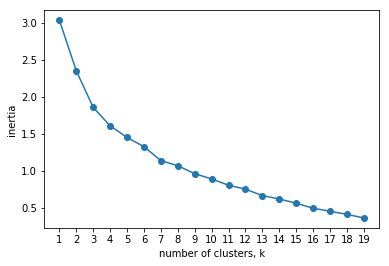

In [361]:
# Plot ks vs inertias
from matplotlib import pyplot as plt
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## Evaluating th cluster

In [345]:
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.000000,0.0,0.03,0.0,0.000000,0.000000,0.0,0.000000,0.030000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.02,0.000000,0.01,0.010000,0.000000,0.0,0.01,0.03,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.01,0.000000,0.070000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.03,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0

In [363]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_with_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(10) # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Health Food Store,Trail,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,6,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bookstore,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Grocery Store,Juice Bar
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Fast Food Restaurant,Gym,Pet Store,Board Shop,Sandwich Place,Brewery,Burger Joint,Burrito Place,Pub,Coffee Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,6,Café,Coffee Shop,Bakery,Gastropub,Italian Restaurant,Brewery,American Restaurant,Seafood Restaurant,Bookstore,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Lawyer,Swim School,Bus Line,Park,Comfort Food Restaurant,College Rec Center,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,6,Gym,Hotel,Department Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Asian Restaurant,Park,Gas Station,Eastern European Restaurant
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,6,Clothing Store,Coffee Shop,Sporting Goods Shop,Salon / Barbershop,Restaurant,Rental Car Location,Café,Chinese Restaurant,Park,Cosmetics Shop
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,Pizza Place,Sandwich Place,Dessert Shop,Sushi Restaurant,Italian Restaurant,Café,Gym,Coffee Shop,Pharmacy,Greek Restaurant
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,4,Park,Playground,Trail,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,6,Pub,Coffee Shop,Pizza Place,Supermarket,Sushi Restaurant,Sports Bar,Fried Chicken Joint,Restaurant,American Restaurant,Liquor Store


In [332]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       1, 0, 4, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0])

In [364]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=7
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [282]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 7
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

TypeError: list indices must be integers or slices, not float

In [365]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,East Toronto,0,Fast Food Restaurant,Gym,Pet Store,Board Shop,Sandwich Place,Brewery,Burger Joint,Burrito Place,Pub,Coffee Shop
7,Central Toronto,0,Pizza Place,Sandwich Place,Dessert Shop,Sushi Restaurant,Italian Restaurant,Café,Gym,Coffee Shop,Pharmacy,Greek Restaurant
36,West Toronto,0,Pizza Place,Café,Coffee Shop,Italian Restaurant,Sushi Restaurant,Gym,Gourmet Shop,Restaurant,Pub,Post Office
38,East Toronto,0,Yoga Studio,Auto Workshop,Gym / Fitness Center,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place



## Cluster 2

In [366]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,1,Lawyer,Swim School,Bus Line,Park,Comfort Food Restaurant,College Rec Center,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


## Cluster 3

In [367]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,2,Garden,Ice Cream Shop,Women's Store,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


## Cluster 4

In [368]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,3,Pub,Health Food Store,Trail,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop


## Cluster 5

In [369]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,4,Park,Playground,Trail,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
10,Downtown Toronto,4,Park,Playground,Trail,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


## Cluster 6

In [370]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,5,Park,Jewelry Store,Trail,Sushi Restaurant,Women's Store,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


## Cluster 7

In [371]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,6,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bookstore,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Grocery Store,Juice Bar
3,East Toronto,6,Café,Coffee Shop,Bakery,Gastropub,Italian Restaurant,Brewery,American Restaurant,Seafood Restaurant,Bookstore,Sandwich Place
5,Central Toronto,6,Gym,Hotel,Department Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Asian Restaurant,Park,Gas Station,Eastern European Restaurant
6,Central Toronto,6,Clothing Store,Coffee Shop,Sporting Goods Shop,Salon / Barbershop,Restaurant,Rental Car Location,Café,Chinese Restaurant,Park,Cosmetics Shop
9,Central Toronto,6,Pub,Coffee Shop,Pizza Place,Supermarket,Sushi Restaurant,Sports Bar,Fried Chicken Joint,Restaurant,American Restaurant,Liquor Store
11,Downtown Toronto,6,Coffee Shop,Restaurant,Italian Restaurant,Pet Store,Pizza Place,Café,Bakery,Pub,Sandwich Place,Japanese Restaurant
12,Downtown Toronto,6,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gastropub
13,Downtown Toronto,6,Coffee Shop,Park,Café,Bakery,Pub,Theater,Breakfast Spot,Mexican Restaurant,Restaurant,Ice Cream Shop
14,Downtown Toronto,6,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Restaurant,Ice Cream Shop,Electronics Store,Bakery,Lingerie Store
15,Downtown Toronto,6,Coffee Shop,Café,Restaurant,Hotel,Cosmetics Shop,Bakery,Cocktail Bar,Beer Bar,Clothing Store,Italian Restaurant
